PyTorch - Brain Tumor MRI Classification Using CNN

According to The Johns Hopkins Brain Tumor Center, a brain tumor is a growth of abnormal cells in the brain. The anatomy of the brain is very complex, with different parts responsible for different nervous system functions. Brain tumors can develop in any part of the brain or skull, including its protective lining, the underside of the brain (skull base), the brainstem, the sinuses and the nasal cavity, and many other areas.

Early detection of brain tumors is vital because it significantly expands treatment options and directly correlates with higher survival rates and a better quality of life for patients. Convolutional Neural Networks (CNNs) have become a method for brain tumor detection in classifying and segmenting tumor types from MRI scans.

This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary from various source such as figshare, SARTAJ dataset, and Br35H.

In [7]:
import torch

if torch.cuda.is_available():
    print("GPU detected!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    device = torch.device("cuda")
else:
    print("GPU not detected. Using CPU.")
    device = torch.device("cpu")


GPU detected!
Device name: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA version: 12.1


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
train_dataset = ImageFolder(r'C:\Users\cw_86\OneDrive\Documents\project\brain_tumor_mri_basic\Training')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder(r'C:\Users\cw_86\OneDrive\Documents\project\brain_tumor_mri_basic\Testing')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

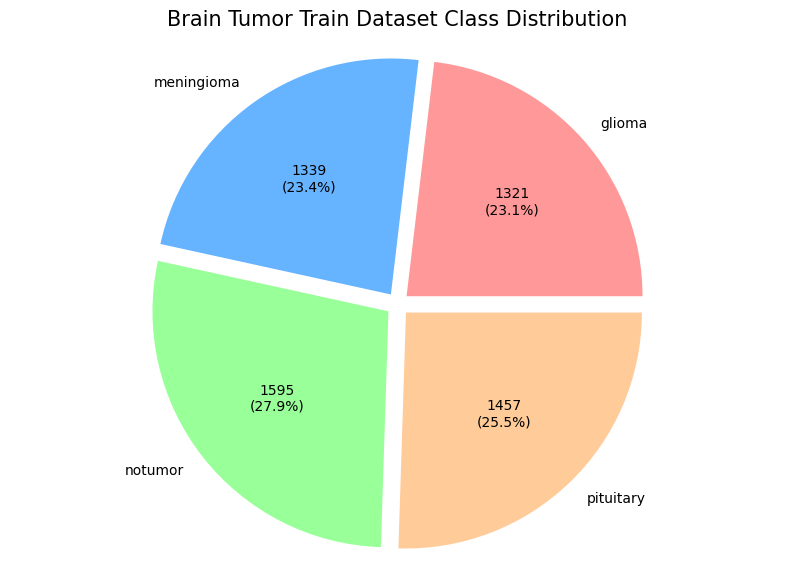

In [14]:
import matplotlib.pyplot as plt

# Access the labels directly from the ImageFolder object
targets = torch.tensor(train_dataset.targets)
# Get unique labels and their respective counts
_, counts = torch.unique(targets, return_counts=True)

# 1. Get data from the defined variables
class_names = train_dataset.classes
class_counts = counts.tolist()

# Function to display both actual count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val}\n({pct:.1f}%)' # Displays: Count \n (Percentage%)
    return my_autopct

# 2. Visualization Settings
plt.figure(figsize=(10, 7))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# 3. Create Pie Chart
plt.pie(
    class_counts,
    labels=class_names,
    autopct=make_autopct(class_counts), # Use custom function for count and %
    colors=colors[:len(class_names)],
    explode=[0.05] * len(class_names)
)

plt.title("Brain Tumor Train Dataset Class Distribution", fontsize=15)
plt.axis('equal')
plt.show()


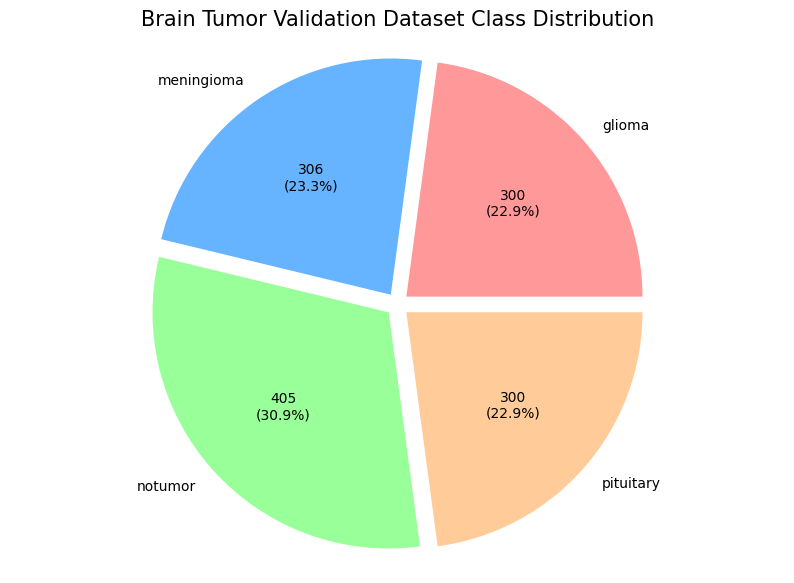

In [15]:
import torch
import matplotlib.pyplot as plt

# 1. Calculate class distribution for the validation dataset
val_targets = torch.tensor(val_dataset.targets)
val_labels, val_counts_tensor = torch.unique(val_targets, return_counts=True)

# Convert to list for plotting
val_class_names = val_dataset.classes
val_class_counts = val_counts_tensor.tolist()

# Function to display both actual count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val}\n({pct:.1f}%)'
    return my_autopct

# 2. Visualization Settings
plt.figure(figsize=(10, 7))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# 3. Create Pie Chart
plt.pie(
    val_class_counts,
    labels=val_class_names,
    autopct=make_autopct(val_class_counts),
    colors=colors[:len(val_class_names)],
    explode=[0.05] * len(val_class_names)
)

plt.title("Brain Tumor Validation Dataset Class Distribution", fontsize=15)
plt.axis('equal')
plt.show()


In [16]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 1. Define TRANSFORMATIONS for Training (With Augmentation)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Define TRANSFORMATIONS for Validation (NO Flips or Rotations)
# This keeps the test data consistent for reliable evaluation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Apply specific transforms to each dataset object
# (Ensure train_dataset and val_dataset were already defined via ImageFolder)
train_dataset.transform = data_transforms
val_dataset.transform = val_transforms

# 4. Update Loaders to apply the new transforms
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Transforms successfully applied to datasets and loaders.")


Transforms successfully applied to datasets and loaders.


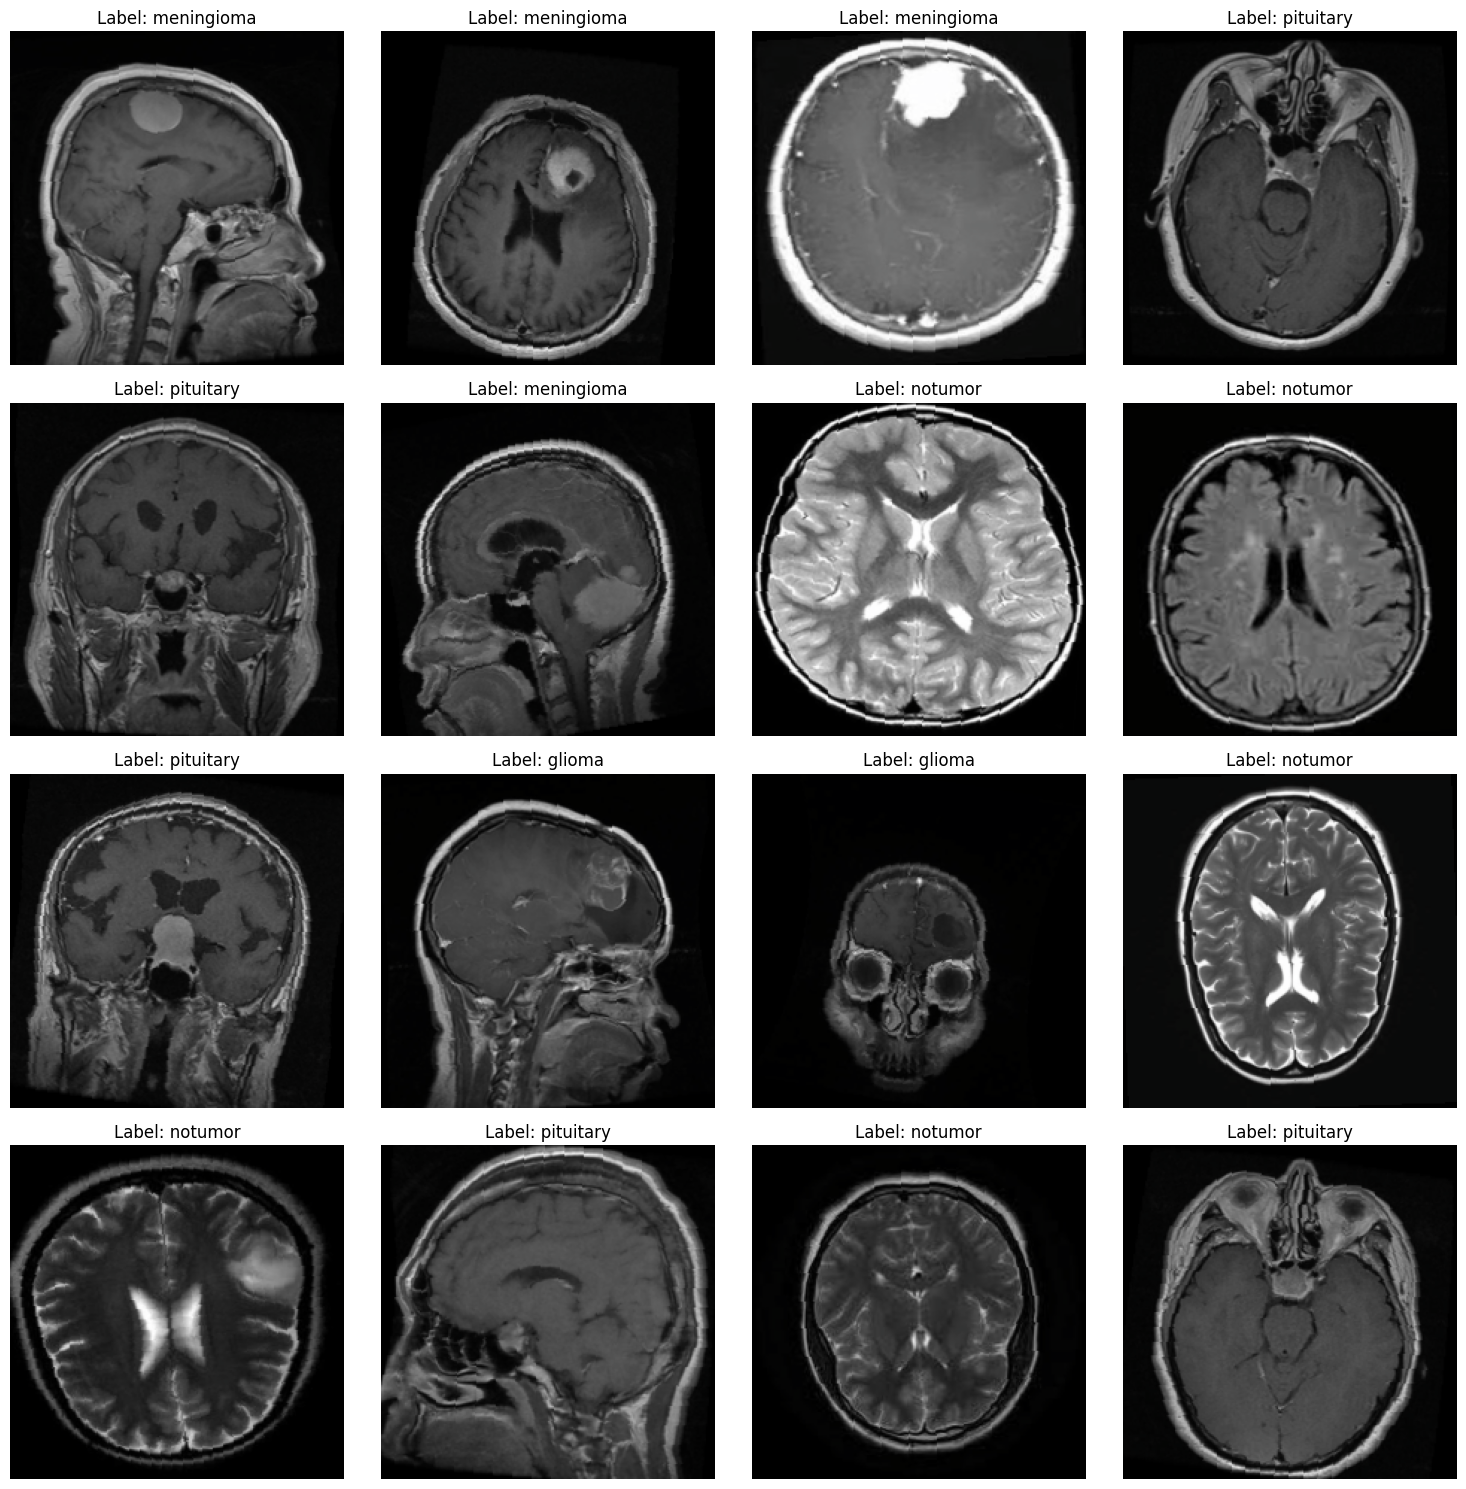

In [17]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score


class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()

        # 1. Feature Extraction Path (Convolutional Layers)
        # This part detects visual patterns like edges, textures, and tumor shapes
        self.features = nn.Sequential(
            # First Layer: Input 3 channels (RGB), Output 16 filters.
            # Kernel 3x3 with padding=1 keeps the spatial dimensions same.
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), # Non-linear activation
            nn.MaxPool2d(kernel_size=2, stride=2), # Reduces size from 224x224 to 112x112

            # Second Layer: Input 16 filters, Output 32 filters.
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size from 112x112 to 56x56
        )

        # 2. Classification Path (Fully Connected Layers)
        # This part makes the final decision based on extracted features
        self.classifier = nn.Sequential(
            # Flattened input: 32 channels * 56px * 56px height/width
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            # Final output layer: mapped to the number of tumor classes (4)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.features(x)

        # Flatten the 3D feature maps into a 1D vector for the linear layer
        # x.size(0) is the batch size
        x = x.view(x.size(0), -1)

        # Pass the vector through the classifier
        x = self.classifier(x)
        return x

# Initialize the custom CNN model for 4 classes
model = TumorClassifier(num_classes=4)

# Move the model to the detected device (GPU/CUDA or CPU)
model.to(device)

# 3. Training Components
# Use CrossEntropyLoss because it's a multi-class classification task
criterion = nn.CrossEntropyLoss()

# Adam optimizer updates model weights based on calculated gradients
# Learning rate is set to 0.001 for a balanced training speed
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Initialize history logs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

num_epochs = 20
best_val_accuracy = 0.0
num_classes = 4 # Based on the dataset (Glioma, Meningioma, Pituitary, No Tumor)

# Helper function to calculate P/R/Acc from accumulated data
def calculate_metrics(all_labels, all_preds):
    # Sklearn handles the complex multi-class averaging easily
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    accuracy = (all_preds == all_labels).mean()
    return precision, recall, accuracy

for epoch in range(num_epochs):
    # ================= TRAINING PHASE =================
    model.train()
    running_train_loss = 0.0
    all_train_labels, all_train_preds = [], []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and labels for epoch-end calculation
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())
    
    # Calculate Epoch Training Metrics
    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_precision, epoch_train_recall, epoch_train_acc = calculate_metrics(
        all_train_labels, all_train_preds
    )
    
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    train_precisions.append(epoch_train_precision)
    train_recalls.append(epoch_train_recall)

    # ================= VALIDATION PHASE =================
    model.eval()
    running_val_loss = 0.0
    all_val_labels, all_val_preds = [], []
    
    with torch.no_grad(): # Critical: Disables gradient to save memory
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            running_val_loss += loss.item() * inputs.size(0)

            # Store predictions and labels for epoch-end calculation
            _, predicted = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())
            
    # Calculate Epoch Validation Metrics
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_precision, epoch_val_recall, epoch_val_acc = calculate_metrics(
        all_val_labels, all_val_preds
    )
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    val_precisions.append(epoch_val_precision)
    val_recalls.append(epoch_val_recall)
    
    # Printing logs
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Acc: {epoch_train_acc:.2%} | Val Acc: {epoch_val_acc:.2%}')
    print(f'Train Prec: {epoch_train_precision:.2f} | Val Prec: {epoch_val_precision:.2f}')
    print(f'Train Rec:  {epoch_train_recall:.2f} | Val Rec:  {epoch_val_recall:.2f}')
    print('-' * 40)
    
    # Save the best model based on REAL validation accuracy
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"[*] New Best Model Saved (Acc: {best_val_accuracy:.2%})")

Epoch [1/20]
Train Acc: 74.19% | Val Acc: 81.62%
Train Prec: 0.73 | Val Prec: 0.82
Train Rec:  0.73 | Val Rec:  0.81
----------------------------------------
[*] New Best Model Saved (Acc: 81.62%)
Epoch [2/20]
Train Acc: 85.85% | Val Acc: 86.42%
Train Prec: 0.85 | Val Prec: 0.86
Train Rec:  0.85 | Val Rec:  0.85
----------------------------------------
[*] New Best Model Saved (Acc: 86.42%)
Epoch [3/20]
Train Acc: 89.79% | Val Acc: 89.93%
Train Prec: 0.89 | Val Prec: 0.90
Train Rec:  0.89 | Val Rec:  0.89
----------------------------------------
[*] New Best Model Saved (Acc: 89.93%)
Epoch [4/20]
Train Acc: 92.12% | Val Acc: 92.30%
Train Prec: 0.92 | Val Prec: 0.92
Train Rec:  0.92 | Val Rec:  0.92
----------------------------------------
[*] New Best Model Saved (Acc: 92.30%)
Epoch [5/20]
Train Acc: 93.79% | Val Acc: 93.44%
Train Prec: 0.94 | Val Prec: 0.94
Train Rec:  0.93 | Val Rec:  0.93
----------------------------------------
[*] New Best Model Saved (Acc: 93.44%)
Epoch [6/20]
Tr

In [19]:
# 1. Initialize the CUSTOM model (not ResNet)
model = TumorClassifier(num_classes=4)

# 2. Load the weights specifically for this architecture
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

# 3. Move to device and set to evaluation mode
model.to(device)
model.eval()

print("\n" + "="*35)
print("       MODEL LOADED SUCCESSFULLY       ")
print("="*35)

# --- RUN FINAL EVALUATION ---
final_correct = 0
final_total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

final_accuracy = final_correct / final_total
print(f'Final Accuracy on Validation Set: {final_accuracy:.2%}')



       MODEL LOADED SUCCESSFULLY       
Final Accuracy on Validation Set: 97.71%


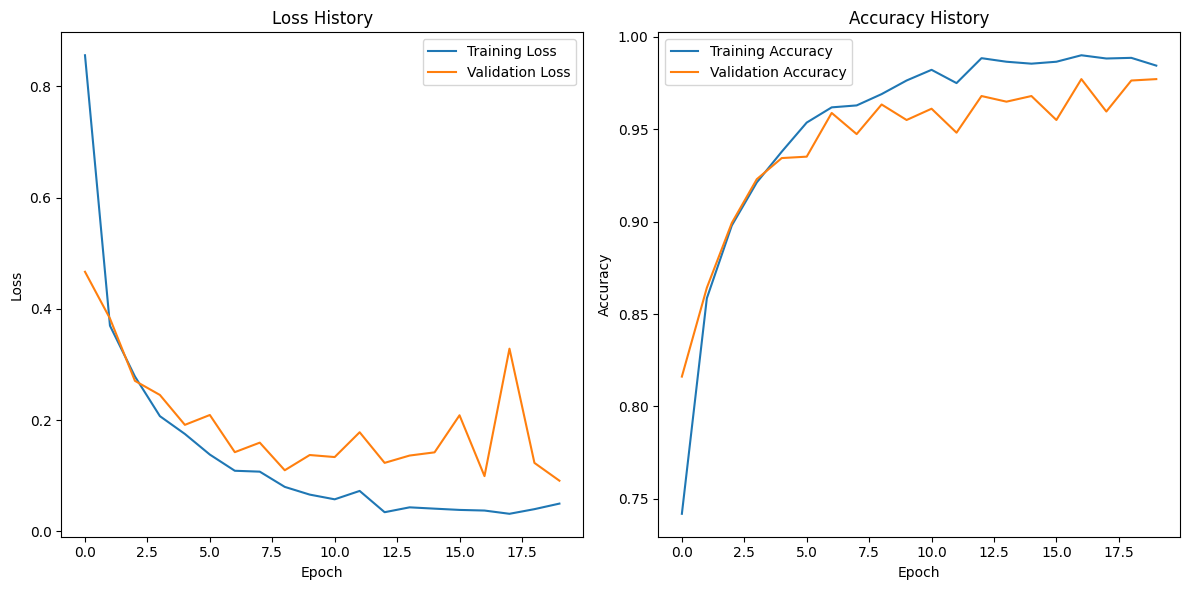

In [20]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

1. Left Graph: Loss History (Error Rate)
This graph displays the error made by the model during training. A lower number means the model is making fewer mistakes.
    Blue Line (Training Loss): Represents the error rate on the data the model is actively learning from.
        Decreases consistently throughout training, starting high (~0.8) and ending very low (~0.02). This means the model is effectively learning to predict the outcomes of the data it has seen during training.
    Orange Line (Validation Loss): Represents the error rate on data the model has never seen before (the validation set).
        Also decreases initially, but around epoch 5-7, it stops improving and begins to fluctuate significantly while generally staying much higher than the training loss.
        The large and growing gap between the training and validation loss lines is the primary indicator of overfitting. The model is memorizing the training data's specific patterns but failing to generalize its knowledge to new, unseen validation data.


2. Right Graph: Accuracy History
This graph displays how often the model makes the correct prediction. A higher number (closer to 1.00 or 100%) is better.
    Blue Line (Training Accuracy): The accuracy on the learned data.
        Increases steadily and reaches near-perfect accuracy (close to 100%) by the end of training. This confirms the model mastered the training set.
    Orange Line (Validation Accuracy): The accuracy on unseen validation data.
        Increases rapidly at first but then plateaus around 95-98% accuracy after epoch 5-6. The performance on unseen data has stopped improving, even as the training accuracy continues to rise.


Conclusion:
1. Good Performance: The model achieved a very high validation accuracy of around 98%.
2. Overfitting Detected: The widening gap between the training and validation metrics confirms the model is overfitting past a certain point.
3. Optimal Stop Point: The best model weights were likely achieved between Epoch 10 and 15, where the validation loss was at its lowest point and accuracy peaked.
4. Early Stopping: The code saves the best_model.pth based on validation accuracy (not training accuracy). It ensures the use of the version of the model from Epoch 10-15, not the flawed one from Epoch 20.

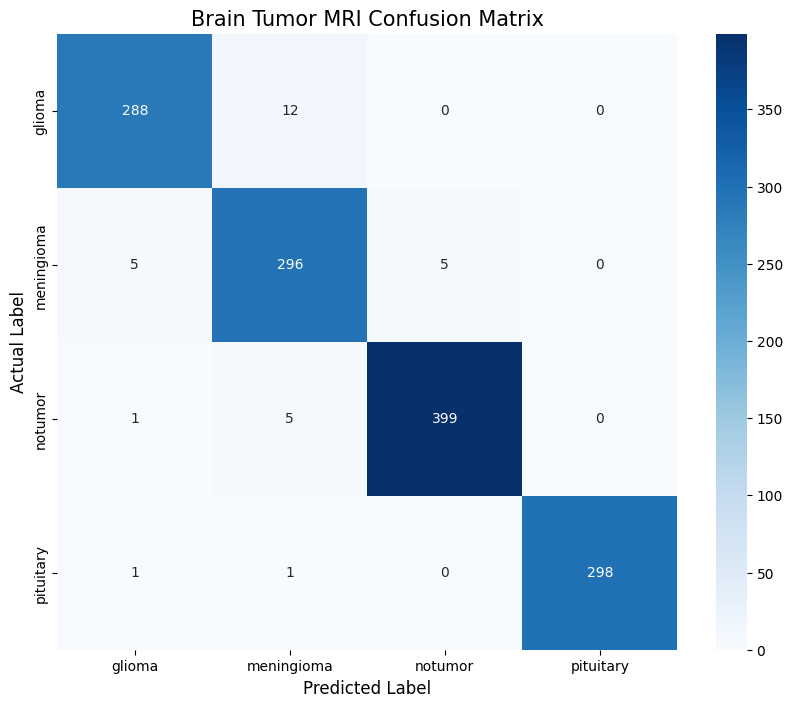


Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       300
  meningioma       0.94      0.97      0.95       306
     notumor       0.99      0.99      0.99       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch

# 1. Gather all predictions and true labels
all_preds = []
all_true_labels = []

model.eval() # Ensure model is in evaluation mode
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        # Get the index of the highest probability
        _, predicted = torch.max(outputs, 1)
        
        # Move data to CPU and convert to numpy lists
        all_preds.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.numpy())

# 2. Generate the Confusion Matrix
# val_dataset.classes contains your labels like ['Glioma', 'Meningioma', etc.]
cm = confusion_matrix(all_true_labels, all_preds)

# 3. Visualize using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,               # Show the numbers in each cell
    fmt='d',                  # Format as integers
    cmap='Blues',             # High contrast color scheme
    xticklabels=val_dataset.classes, 
    yticklabels=val_dataset.classes
)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.title('Brain Tumor MRI Confusion Matrix', fontsize=15)
plt.show()

# 4. Print Detailed Metrics (Precision, Recall, F1-Score)
print("\nDetailed Classification Report:")
print(classification_report(all_true_labels, all_preds, target_names=val_dataset.classes))


1. The model predicted "meningioma" for 12 actual glioma cases and "glioma" for 5 actual meningioma cases. This can be the model's biggest "blind spot". The jitter in the loss history is likely just the model struggling to resolve that final 2–4% of confusion between Gliomas and Meningiomas.

2. Even with such high accuracy, the spikes in loss graph happen because the model is highly confident when it's right, but it might also be highly confident when it makes one of these few mistakes. In Cross-Entropy Loss, being "wrong and confident" creates a massive spike in the loss value.

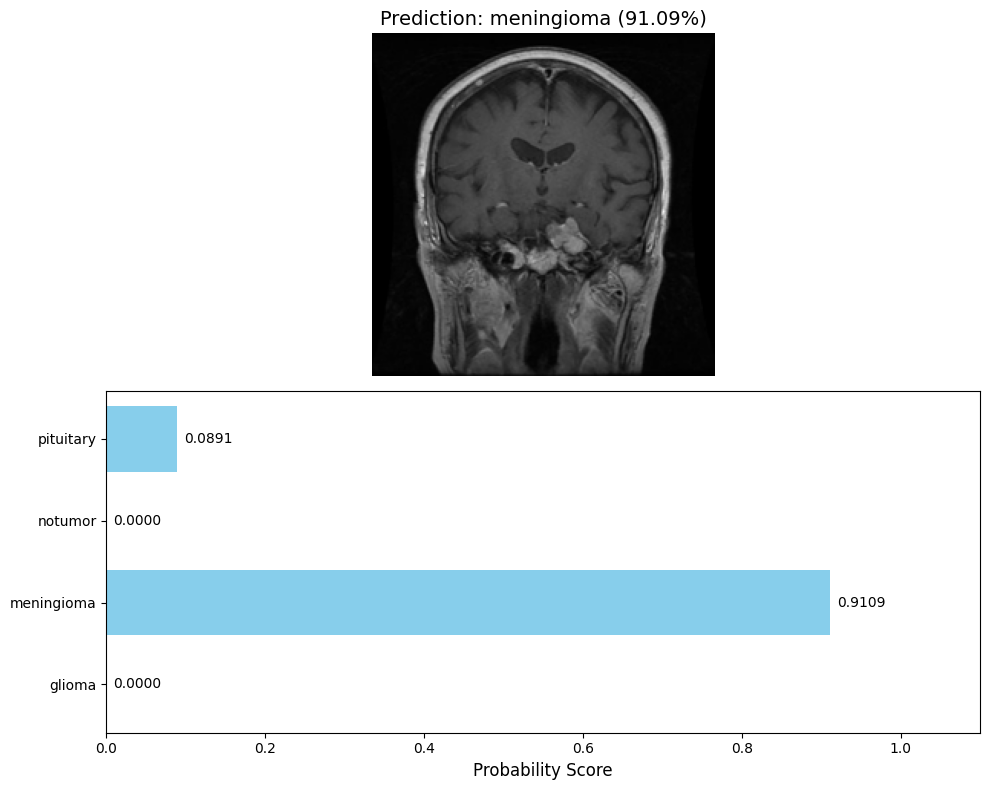

In [33]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def predict_pytorch(img_path, model, class_names):
    """
    Predicts the brain tumor class for a given MRI image using a trained PyTorch model.
    """
    # 1. Load and Preprocess the Image
    # Convert to RGB to ensure 3 channels (matches training data)
    img = Image.open(img_path).convert('RGB')
    
    # Apply identical transformations used during validation
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # Normalize using ImageNet standards
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transform image and add a batch dimension (1, 3, 224, 224)
    input_tensor = preprocess(img).unsqueeze(0) 
    input_tensor = input_tensor.to(device)

    # 2. Model Inference
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor)
        # Convert raw output (logits) to probabilities using Softmax
        probabilities = F.softmax(output, dim=1)[0]
    
    # Move to CPU for plotting
    probs = probabilities.cpu().numpy()
    predicted_class_idx = np.argmax(probs)
    predicted_label = class_names[predicted_class_idx]
    
    # 3. Visualization
    plt.figure(figsize=(10, 8))
    
    # Subplot 1: Original Image
    plt.subplot(2, 1, 1)
    plt.imshow(img.resize((224, 224)))
    plt.title(f"Prediction: {predicted_label} ({probs[predicted_class_idx]:.2%})", fontsize=14)
    plt.axis('off')
    
    # Subplot 2: Probability Bar Chart
    plt.subplot(2, 1, 2)
    bars = plt.barh(class_names, probs, color='skyblue')
    plt.xlabel('Probability Score', fontsize=12)
    plt.xlim(0, 1.1) # Maximum scale of 100% + padding
    
    # Add numerical labels to the end of each bar
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.4f', padding=5)
    
    plt.tight_layout()
    plt.show()

# --- Execution ---
image_path = r'C:\Users\cw_86\OneDrive\Documents\project\brain_tumor_mri_basic\Testing\meningioma\Te-me_0162.jpg'

predict_pytorch(image_path, model, train_dataset.classes)


The model correctly identified a Meningioma with 91.09% confidence. While high, the 8.91% uncertainty towards "pituitary" suggested the model's internal feature boundaries weren't yet fully refined.

The "jitter" in the validation accuracy suggests that the learning rate might be too high for the end of the training. The model is "jumping" over the optimal solution. One way to overcome this problem is to use Learning Rate (LR) Scheduler. The use of the Learning Rate (LR) Scheduler method will be explained in a separate file (brain_tumor_scheduler).